In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
plt.style.use("dark_background")
%matplotlib inline

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

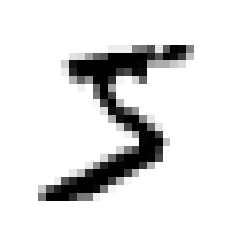

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [7]:
y[0]

'5'

In [8]:
y = y.astype(np.uint8)

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary Classifier

In [10]:
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [11]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
sgd_clf.predict([some_digit])  # == X[0]

array([ True])

# Performance Measures

## Measuring Accuracy Using Cross-Validation

### Implementing Cross-Validation, incase need more control than sci-kit learn's cross_val_score() function

In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

c:\users\eavic\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [14]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [15]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

# Confusion Matrix

In [17]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [18]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [19]:
# Pretend we reached perfection
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

# Precision and Recall

In [20]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [21]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [22]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [25]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

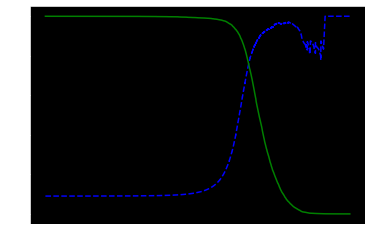

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.show()
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [28]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [29]:
y_train_pred_90 = (y_scores > threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [30]:
precision_score(y_train_5, y_train_pred_90)

0.9

In [31]:
recall_score(y_train_5, y_train_pred_90)

0.47980077476480354

# The ROC Curve

In [32]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

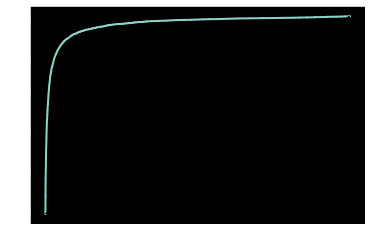

In [33]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
plot_roc_curve(fpr, tpr)
plt.show()

In [34]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [35]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [36]:
y_scores_forest = y_probas_forest[:, 1]  # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

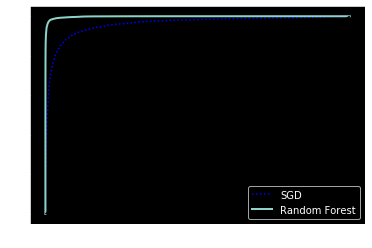

In [37]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [38]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# Multiclass Classification

In [39]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [40]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [41]:
np.argmax(some_digit_scores)

5

In [42]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [43]:
svm_clf.classes_[5]  # in general won't be so lucky


5

## one-versus-one or one-versus-the-rest classifier

In [44]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [45]:
len(ovr_clf.estimators_)

10

## Training an SGDClassifier (or RandomForestClassifier) is just as easy.

In [46]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [47]:
sgd_clf.decision_function([some_digit])

array([[-3.54045013e+04, -4.54994824e+04, -9.25237955e+03,
         5.91792362e+02, -2.48401535e+04,  2.60623370e+01,
        -2.71672557e+04, -1.36612601e+04, -8.60404369e+03,
        -1.06296841e+04]])

In [48]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.88085, 0.88195, 0.86255])

### Simply scaling the inputs increases accuracy from 84% to 89%

In [49]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.9028 , 0.89675, 0.9016 ])

# Error Analysis

In [50]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5579,    0,   22,    6,    9,   43,   35,    6,  222,    1],
       [   0, 6397,   37,   24,    4,   44,    4,    6,  216,   10],
       [  27,   27, 5230,   90,   72,   25,   69,   39,  372,    7],
       [  22,   17,  116, 5226,    2,  202,   26,   39,  408,   73],
       [  11,   14,   47,    9, 5193,   13,   35,   25,  331,  164],
       [  28,   15,   29,  167,   52, 4434,   75,   16,  543,   62],
       [  29,   15,   41,    2,   41,   93, 5561,    5,  130,    1],
       [  20,    9,   51,   30,   48,   11,    3, 5687,  189,  217],
       [  17,   61,   48,   89,    3,  125,   24,   10, 5433,   41],
       [  22,   18,   30,   64,  117,   31,    1,  176,  369, 5121]],
      dtype=int64)

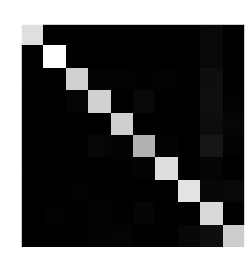

In [51]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [52]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

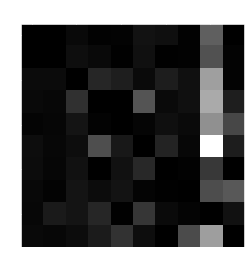

In [53]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [54]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [55]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

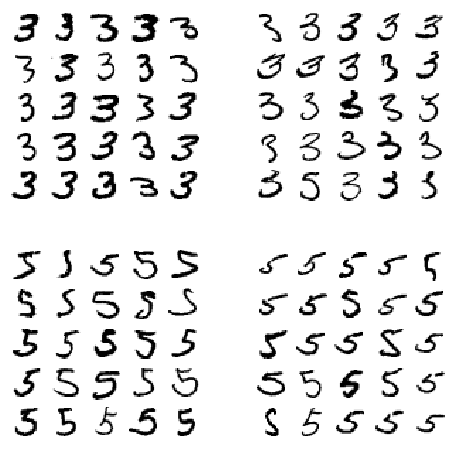

In [56]:
plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# Multilabel Classification

In [57]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([some_digit])

array([[False,  True]])

In [58]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

# Multioutput Classification

Input (image w/ noise) => KNN => Output (image denoised)

In [59]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [60]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = plt.cm.binary,
               interpolation="nearest")
    plt.axis("off")

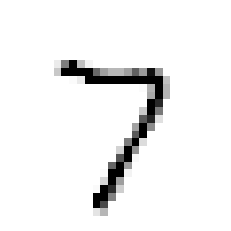

In [61]:
some_index = 0
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
